In [1]:
!pip install -U -qq gdown kaggle

from google.colab import drive
drive.mount('/content/drive')

import os
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/all_AI_code/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [49]:
import os
import json
import zipfile
import shutil
import random
from pathlib import Path
from glob import glob
import cv2
import PIL
from PIL import Image, ImageOps
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# download competition dataset
!kaggle competitions download -c hackathon-online-2022-image-processing

 97% 404M/415M [00:06<00:00, 48.5MB/s]
100% 415M/415M [00:06<00:00, 66.2MB/s]


In [4]:
!mkdir /content/data/

In [5]:
with zipfile.ZipFile("./hackathon-online-2022-image-processing.zip", "r") as zip_ref:
    print("Unzipping main_zip data...")
    zip_ref.extractall()

Unzipping main_zip data...


In [6]:
with zipfile.ZipFile("./IM_Test.zipfile", "r") as zip_ref:
    print("Unzipping train data...")
    zip_ref.extractall("/content/data/")

with zipfile.ZipFile("./IM_Train.zipfile", "r") as zip_ref:
    print("Unzipping train data...")
    zip_ref.extractall("/content/data/")

Unzipping train data...
Unzipping train data...


In [7]:
with zipfile.ZipFile("/content/data/IM_Train.zipfile", "r") as zip_ref:
    print("Unzipping train data...")
    zip_ref.extractall("/content/data/")

with zipfile.ZipFile("/content/data/IM_Test.zipfile", "r") as zip_ref:
    print("Unzipping train data...")
    zip_ref.extractall("/content/data/")

Unzipping train data...
Unzipping train data...


In [8]:
!rm /content/IM_Test.zipfile /content/IM_Train.zipfile /content/hackathon-online-2022-image-processing.zip /content/data/IM_Test.zipfile /content/data/IM_Train.zipfile

In [9]:
# train data
ls = glob("/content/data/train/*/*.png")
len(ls)

73257

In [10]:
df_data = pd.DataFrame(ls,columns=['path'])
df_data['label'] = df_data['path'].map(lambda x: int(x.split('/')[-2]))
df_data.sample(3)

,path,label
67001,/content/data/train/2/5138.0.png,2
43681,/content/data/train/4/18385.1.png,4
41944,/content/data/train/4/29063.1.png,4


In [11]:
def img_property(df):
        W, H, ratio, Area = [],[],[],[]
        for i in tqdm(df.index, desc='property is adding...'):
                img2 = cv2.imread(str(df['path'][i]))
                w,h,c = img2.shape
                W.append(w)
                H.append(h)
                ratio.append(w/h)
                Area.append(w*h)
        df['W'] = W
        df['H'] = H
        df['ratio'] = ratio
        df['Area'] = Area

img_property(df_data)
df_data.sample(3)

property is adding...: 100%|██████████| 73257/73257 [00:07<00:00, 9782.50it/s]


,path,label,W,H,ratio,Area
9471,/content/data/train/8/24670.1.png,8,18,9,2.000000,162
69060,/content/data/train/2/28191.1.png,2,25,16,1.562500,400
22454,/content/data/train/1/7776.0.png,1,37,12,3.083333,444


<Axes: >

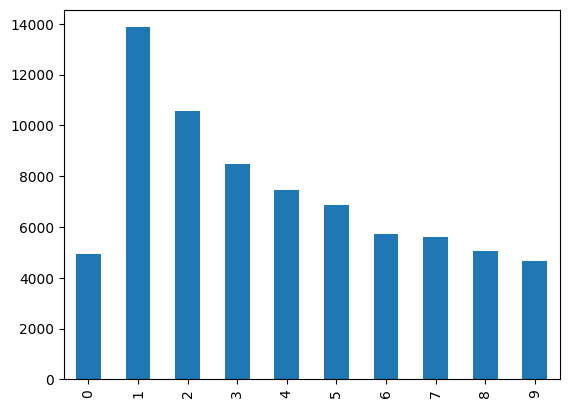

In [12]:
df_data['label'].value_counts()\
  .sort_index()\
  .plot.bar()

In [15]:
# test data
with open("/content/data/IM_Test/IM_Test.json") as json_file:
    datas = json.load(json_file)

df_json = pd.json_normalize(datas)
df_json.sample(3)

,filename,bboxes
12409,12410.png,"[{'bbox_id': 0, 'x1': 55, 'x2': 72, 'y1': 21, ..."
7184,7185.png,"[{'bbox_id': 0, 'x1': 79, 'x2': 90, 'y1': 29, ..."
680,681.png,"[{'bbox_id': 0, 'x1': 101, 'x2': 112, 'y1': 26..."


In [16]:
!mkdir /content/data/croped_images/

mkdir: cannot create directory ‘/content/data/croped_images/’: File exists


In [20]:
df_test = pd.DataFrame(columns=['path', 'filename', 'imageid_boxid'])

for i in tqdm(df_json.index, desc='Croping...'):
    pth = f"/content/data/IM_Test/IM_Test/{i+1}.png"
    img = cv2.imread(pth)

    for j in df_json['bboxes'][i]:
        name = str(i+1) +'_' + str(j['bbox_id'])
        des_pth = f"/content/data/croped_images/{name}.png"
        df_test.loc[len(df_test)] = [des_pth, df_json['filename'][i], name]

        crop_img = img[j['y1']:j['y2'], j['x1']:j['x2']]
        cv2.imwrite(str(des_pth), crop_img)

Croping...: 100%|██████████| 13068/13068 [01:34<00:00, 137.61it/s]


In [21]:
img_property(df_test)
df_test.sample(3)

property is adding...: 100%|██████████| 26032/26032 [00:01<00:00, 14652.51it/s]


,path,filename,imageid_boxid,W,H,ratio,Area
5216,/content/data/croped_images/2630_0.png,2630.png,2630_0,44,25,1.760000,1100
12511,/content/data/croped_images/6306_0.png,6306.png,6306_0,24,14,1.714286,336
328,/content/data/croped_images/174_0.png,174.png,174_0,43,23,1.869565,989


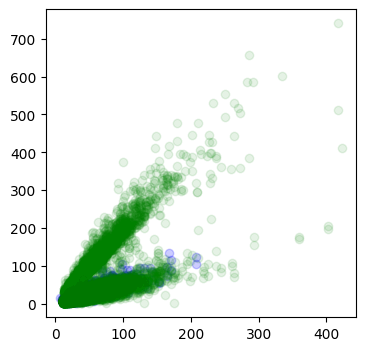

In [26]:
plt.figure(figsize = (4, 4))
plt.scatter(df_test["W"], df_test["H"], color='b', alpha=0.2)
plt.scatter(df_data["W"], df_data["H"], color='g', alpha=0.1)
plt.show()

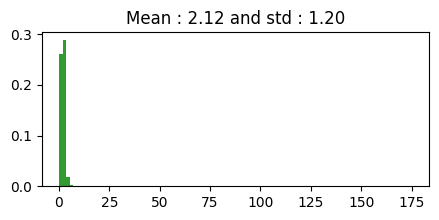

In [34]:
plt.figure(figsize = (5, 2))
mean, std = df_data['ratio'].mean() , df_data['ratio'].std()
plt.hist(df_data['ratio'], bins=100, density=True, alpha=0.8, color='green')
title = "Mean : {:.2f} and std : {:.2f}".format(mean, std)
plt.title(title)
plt.show()

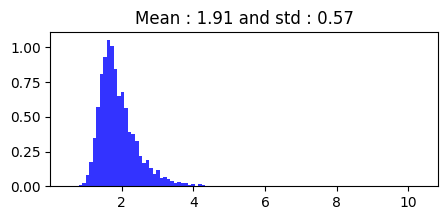

In [33]:
plt.figure(figsize = (5, 2))
mean, std = df_test['ratio'].mean() , df_test['ratio'].std()
plt.hist(df_test['ratio'], bins=100, density=True, alpha=0.8, color='blue')
title = "Mean : {:.2f} and std : {:.2f}".format(mean, std)
plt.title(title)
plt.show()

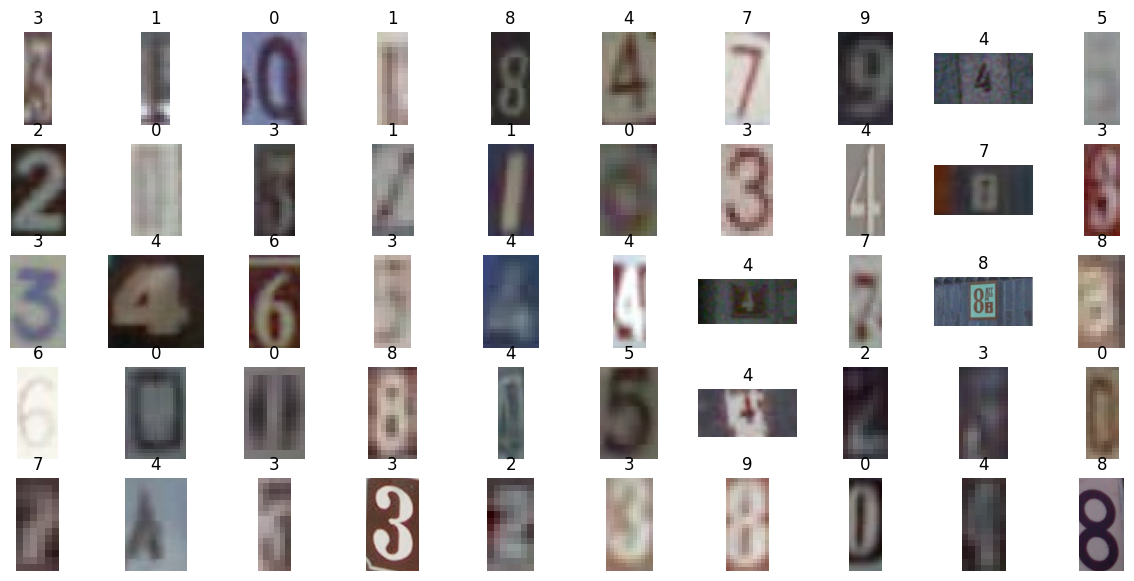

In [84]:
ls = df_data['path'].sample(50).tolist()
plt.figure(figsize=(15, 7))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  img = cv2.imread(ls[i])
  # h,w,_ = img.shape
  # if w>h:
  #   img = img[:,int(w/2-h/2):int(w/2+h/2)]
  plt.imshow(img)
  plt.title(ls[i].split('/')[-2])
  plt.axis('off')

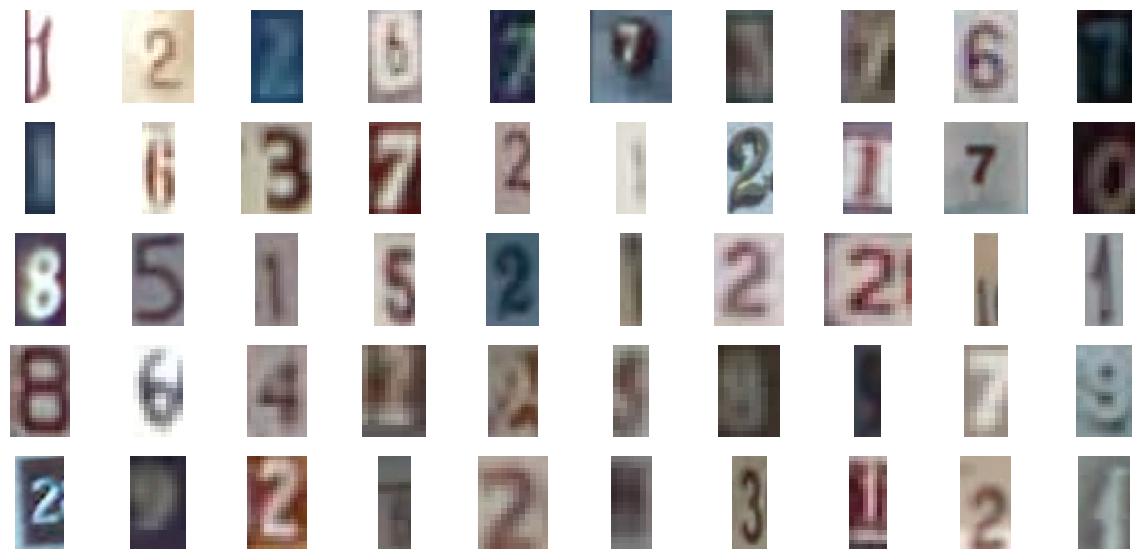

In [85]:
ls = df_test['path'].sample(50).tolist()
plt.figure(figsize=(15, 7))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  img = cv2.imread(ls[i])
  # h,w,_ = img.shape
  # if w>h:
  #   img = img[:,int(w/2-h/2):int(w/2+h/2)]
  plt.imshow(img)
  # plt.title(ls[i].split('/')[-2])
  plt.axis('off')

In [82]:
def preprocess(path, IMG_SIZE=224, mode='train'):
  if mode == 'train':
    img = cv2.imread(path)
    h,w,_ = img.shape
    if w>h:
      img = img[:,int(w/2-h/2):int(w/2+h/2)]
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(image_rgb)
    img = ImageOps.contain(img, (IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    img = ImageOps.autocontrast(img)
    img = ImageOps.grayscale(img)
    img = ImageOps.autocontrast(img)
    if random.randint(0,1)==1:
      img = ImageOps.invert(img)
      img = ImageOps.pad(img, (IMG_SIZE, IMG_SIZE),method=Image.Resampling.LANCZOS, centering=(0,0))
    else:
      img = ImageOps.pad(img, (IMG_SIZE, IMG_SIZE),method=Image.Resampling.LANCZOS, centering=(0.5,0.5))
  else:
    img = Image.open(path)
    img = ImageOps.contain(img, (IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    img = ImageOps.autocontrast(img)
    img = ImageOps.grayscale(img)
    img = ImageOps.autocontrast(img)
    img = ImageOps.pad(img, (IMG_SIZE, IMG_SIZE), centering=(0, 0))
  return np.array(img.convert("RGB"))

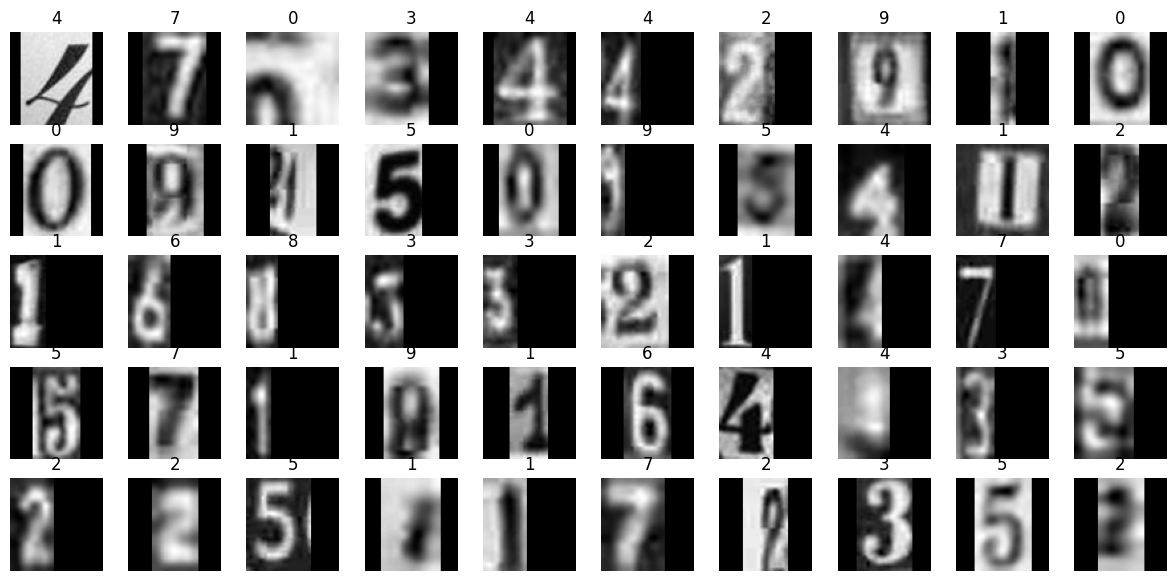

In [79]:
ls = df_data['path'].sample(50).tolist()
plt.figure(figsize=(15, 7))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  img = preprocess(ls[i])
  plt.imshow(img)
  plt.title(ls[i].split('/')[-2])
  plt.axis('off')

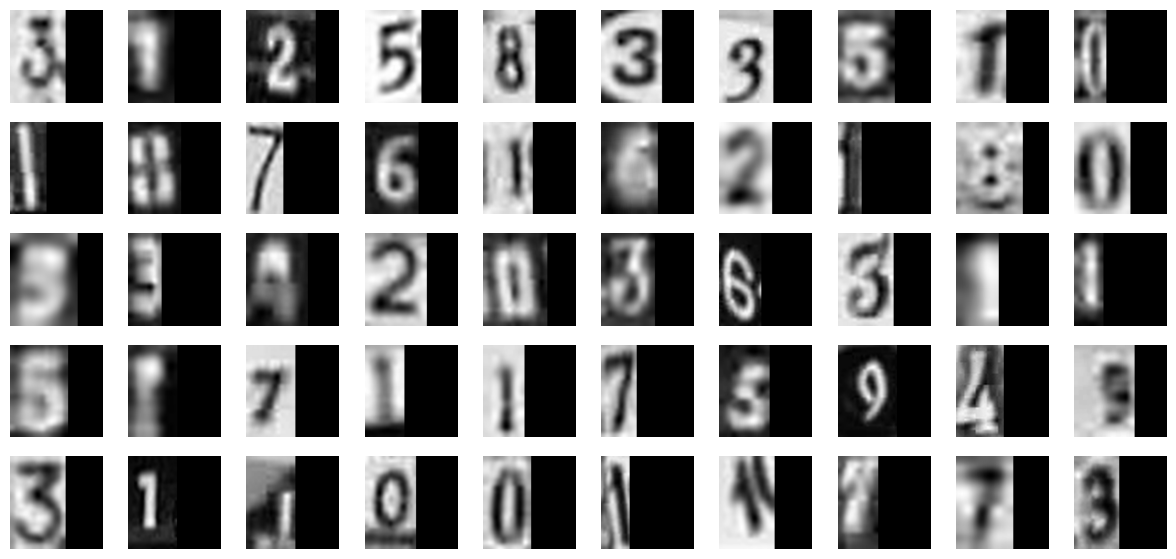

In [83]:
ls = df_test['path'].sample(50).tolist()
plt.figure(figsize=(15, 7))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  img = preprocess(ls[i], mode='test')
  plt.imshow(img)
  # plt.title(ls[i].split('/')[-2])
  plt.axis('off')